<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/04_digging_further_into_data_wrangling/04_estimating_building_height.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This exercise aims to build on your knowledge of the big-four data science libraries to use Kestrel atmospheric measurement devices to estimate the height difference between the ground floor and sixth floor of the Geology building.

# Background

Air pressure monotonically decreases with height in the atmosphere.  This is simply due to the fact that *air pressure is a measure of the weight of everything above*.  So higher up in the atmosphere there is less atmosphere (weight) above, and pressure decreases.

One of the basic principles of fluid dynamics is that a *pressure gradient*--a change in pressure over some distance--exerts a net force on the fluid that, in the absence of other forces, would cause the fluid to move.  So why then does the atmosphere not flow away to space in response to this pressure gradient?

To a very good approximation, the atmosphere is in *hydrostatic balance*, meaning that the vertical pressure gradient is balanced by the force of gravity on the air; gravity effectively negates the pressure gradient force.  This leads to one of the most essential equations in atmospheric science:

$$ \frac{\partial p}{\partial z} = -\rho g$$

where $p$ is the atmospheric pressure, $z$ is height away from the surface, $\rho$ is air density, and $g$ is the gravitational acceleration (we'll use $g \approx 9.806~\text{m s}^{-2}$ here).

If we combine this with the ideal gas law (written in a form that is convenient for atmospheric gasses, where $R_d \approx 287~\text{J kg}^{-1}\text{K}^{-1}$ represents a constant for air with the composition of Earth's atmosphere), we get a differential equation for pressure.

$$\text{Ideal gas law: }~p = \rho R_d T \to $$

$$ \frac{\partial p}{\partial z} = - \frac{p g}{R_d T} $$

We can approximate the derivatives in this equation using finite differences: $\partial p/\partial z \to \Delta p / \Delta z$, where $\Delta$ represents a (presumably small) difference between two pressure or height measurements.  We can then use this to solve for the change in height as a function of changes in pressure:

$$ \Delta z \approx - \frac{R_d T}{g} \frac{\Delta p}{p}$$

# Estimating height

Now imagine that we have a device that records pressure and temperature every second or so.  If you take that device and walk up a set of stairs, the recorded pressure will drop a bit for every second that you're ascending.  A pair of measurements taken at consecutive times can be used to estimate $\Delta p$, and the average of the two measurements can be used to estimate $p$ and $T$ over tha same time frame.  These values can be plugged in to the above formula to estimate the change in height between the two measurements.  The sum of all the changes in height then gives an estimate of the total change in height; we will have numerically integrated the differential equation that comes from combining hydrostatic balance and the ideal gas law.

## Instructions

1. form groups of two or three
1. acquaint yourself with the Kestrel measuring devices, and pair it to at least one of your phones using [Kestrel Link](https://kestrelinstruments.com/link-connectivity)
1. ensure that you can record measurements and export them to csv
1. take the kestrel device down to the ground floor of the Geology building; go to the loop
1. start recording
1. either walk up the stairwell, or take the elevator, up to the 7th floor (you can only access this floor from the western stairwell)
1. end recording
1. export the data to a CSV file and add it to your course git folder (into a folder for lesson 04)
1. estimate the difference in height between the two floors using the method above (*hint*: you should use `pandas`, and you should be able to make a new column for the calculation of $\Delta p$ and $\Delta z$ for each measurement, and then use the `.sum()` method)

The data was gathered by Peyton and Janie

In [2]:
"""import libraries"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

In [3]:
"""read the Kestrel data file"""
filename = r"C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\lesson04\WEATHER_-_2406604_Sep_15,_2023___2_54_34_PM.csv"


#read in data file
kestrel = pd.read_csv(filename, header = 1, skiprows = 3, usecols=range(0,16), parse_dates=[0], delimiter = None, na_values = "--")
kestrel.head()

,YYYY-MM-DD HH:MM:SS,°F,°F.1,%,inHg,ft,inHg.1,mph,°F.2,°F.3,ft.1,mph.1,mph.2,Deg,Deg.1,°F.4
0,2023-09-15 14:52:26,70.4,58.8,50.2,29.29,576,29.30,0.0,69.4,51.0,1622,NaN,NaN,NaN,NaN,70.3
1,2023-09-15 14:52:31,70.4,58.3,49.1,29.29,581,29.29,0.0,69.4,50.4,1619,NaN,NaN,NaN,NaN,70.3
2,2023-09-15 14:52:36,70.2,58.1,48.5,29.30,576,29.30,0.0,69.1,49.9,1600,NaN,NaN,NaN,NaN,70.2
3,2023-09-15 14:52:41,70.0,58.1,48.8,29.28,584,29.29,0.0,68.9,49.9,1600,NaN,NaN,NaN,NaN,70.0
4,2023-09-15 14:52:46,69.9,57.9,49.2,29.28,585,29.28,0.0,68.5,50.0,1595,NaN,NaN,NaN,NaN,69.8


Text(0.5, 0, 'Time')

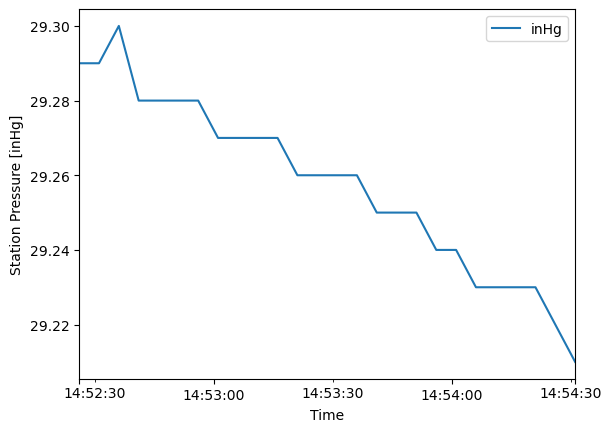

In [4]:
'''plot the data'''
kestrel.plot(x = "YYYY-MM-DD HH:MM:SS", y = "inHg");
plt.ylabel("Station Pressure [inHg]")
plt.xlabel("Time")

We started at the bottom of the stairs and walked up. At the beginning, Peyton placed the kestrel device on the floor tile of the ground for good measure.

And with a time-between-measurements of 5 seconds, we may have made too-good time in how long it took getting to the top.

### Create delta z and delta p values


We will add columns in the dataset for change in pressure, average temperature, and average pressure between two nearby measurements.

We will also convert temperature to Kelvin and pressure to Pa to work with our units.

In [5]:
"""add columns and find dK and dT"""
 
kestrel["avg_K"] = ((kestrel["°F"] + kestrel["°F"].shift(1))/2 + 459.67) * 5/9 # also convert to Kelvin
kestrel["avg_Pa"] = (kestrel["inHg"] + kestrel["inHg"].shift(1) )/2 * 3386.39 # also convert to Pascal
kestrel["dPa"] = kestrel["inHg"].diff() * 3386.39 # also convert to Pascal


# set the first value to zero
kestrel.loc[0,"avg_K"] = 0
kestrel.loc[0,"dPa"] = 0
kestrel.loc[0,"avg_Pa"] = 0
kestrel.head()

,YYYY-MM-DD HH:MM:SS,°F,°F.1,%,inHg,ft,inHg.1,mph,°F.2,°F.3,ft.1,mph.1,mph.2,Deg,Deg.1,°F.4,avg_K,avg_Pa,dPa
0,2023-09-15 14:52:26,70.4,58.8,50.2,29.29,576,29.30,0.0,69.4,51.0,1622,NaN,NaN,NaN,NaN,70.3,0.000000,0.00000,0.0000
1,2023-09-15 14:52:31,70.4,58.3,49.1,29.29,581,29.29,0.0,69.4,50.4,1619,NaN,NaN,NaN,NaN,70.3,294.483333,99187.36310,0.0000
2,2023-09-15 14:52:36,70.2,58.1,48.5,29.30,576,29.30,0.0,69.1,49.9,1600,NaN,NaN,NaN,NaN,70.2,294.427778,99204.29505,33.8639
3,2023-09-15 14:52:41,70.0,58.1,48.8,29.28,584,29.29,0.0,68.9,49.9,1600,NaN,NaN,NaN,NaN,70.0,294.316667,99187.36310,-67.7278
4,2023-09-15 14:52:46,69.9,57.9,49.2,29.28,585,29.28,0.0,68.5,50.0,1595,NaN,NaN,NaN,NaN,69.8,294.233333,99153.49920,0.0000


### calculate change in height between each point

In [6]:
"""import constants"""
Rd = 287 # J/kg/K gas constnat
g = 9.806 #9.8 ish m/s/s gravity

In [7]:
# calculate the change in height between each measurement
kestrel["d_H"] = - Rd*kestrel["avg_K"]*kestrel["dPa"]/(g*kestrel["avg_Pa"])

kestrel["d_H_sum"] = kestrel["d_H"].cumsum()
print("estimated height is", kestrel["d_H_sum"].iloc[-1], "meters")

estimated height is 23.54744198366253 meters


The Kestrel data has a column for feet. Check the data using the range of this column.

In [8]:
meters = 0.3048 * (kestrel["ft"].max() - kestrel["ft"].min())
meters

23.4696

That's pretty close!